# Team Frequency Analysis

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from collections import Counter
from textblob import TextBlob, Word
import nltk
from nltk.corpus import stopwords
import string
import spacy
import seaborn as sns

In [43]:
%matplotlib inline

In [44]:
articles_list = pd.read_csv('nyt_scrape/articles_list_w_date.csv',parse_dates=['date'])

In [45]:
articles_list.head(2)

,published_date,article_urls,article_summary,article_headline,title,date
0,2018-06-09T17:31:27+0000,https://www.nytimes.com/2018/06/09/sports/nba-...,"Accused of making the sport uncompetitive, the...",The Warriors Were Dominant. But How Dominant?,nba-finals-sweep,2018-06-09
1,2018-06-09T01:26:37+0000,https://www.nytimes.com/2018/06/08/movies/kyri...,"In his most extensive comments to date, the Bo...",Kyrie Irving Doesn’t Know if the Earth Is Roun...,kyrie-irving-nba-celtics-earth,2018-06-09


## Total Mentions across Corpus:

In [46]:
dir_list = os.listdir('nyt_scrape/new_articles')

In [47]:
corpus = ''

for article in dir_list:
    with open(f'nyt_scrape/new_articles/{article}') as f:
        corpus += f.read()
        corpus += '\n'

corpus = corpus.replace('’','').replace('”','').replace('“','').replace('—','')

In [48]:
corpus_blob = TextBlob(corpus)

In [49]:
tags = corpus_blob.pos_tags
tags = [tag for tag in tags if tag[1] in {'NN','NNS','NNP','NNPS'}]
tags = [Word(tag[0].lower()) for tag in tags]
lemma_tags = [tag.lemmatize() for tag in tags]
lemma_tags = [tag for tag in tags if tag not in ['s','t']]
c2 = Counter(lemma_tags)

In [50]:
team_names = pd.read_csv('team_names.csv')

In [51]:
playoff_dict = {0:'DNQ',1:'First Round',2:'Second Round',3:'Conference Finals',4:'NBA Finals',5:'Champion'}
inverse_playoff_dict = dict(zip(playoff_dict.values(),playoff_dict.keys()))

In [52]:
names = list(team_names['Name'])
team_names['noun_occurrences'] = [c2[name.lower()] for name in names]

In [53]:
team_names.sort_values(['noun_occurrences'],ascending=False).head()

,Name,Wins,Playoffs,Conference,New York Team,noun_occurrences
6,Knicks,29,0,E,1,590
2,Warriors,58,5,W,0,521
1,Cavaliers,50,4,E,0,370
3,Celtics,55,3,E,0,302
8,Rockets,65,3,W,0,296


In [54]:
team_names['playoff_round'] = team_names.Playoffs.apply(lambda x : playoff_dict[x])

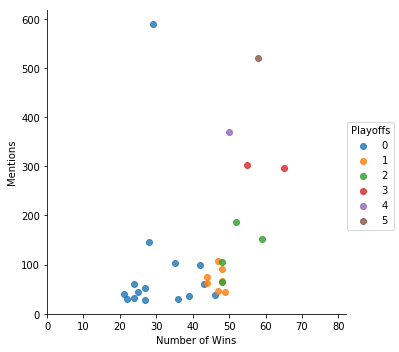

In [55]:
g = sns.lmplot(x="Wins", y="noun_occurrences", hue = "playoff_round",data=team_names,fit_reg = False, legend = True)
g.set_axis_labels(x_var = "Number of Wins", y_var = "Mentions")
g.axes[0,0].set_xlim(0,82)
plt.show()

This graph shows that teams who reach further in the playoffs and who have more wins tend to have significantly more mentions. Notable exceptions to this are the New York Knicks and the Brooklyn Nets - the two local teams that we would expect to be reported more.

# Regular Season Play:

Let's try restricting our analysis to articles written before the start of the postseason to see if teams reaching further in the playoffs are also written more about in the regular season.

In [56]:
postseason_start = pd.to_datetime('2018-04-14')

In [57]:
articles_list['regular_season'] = articles_list.date < postseason_start

In [58]:
regular_season_corpus = ''

for index, row in articles_list.iterrows():
    if row['regular_season']:
        article = row["article_urls"].replace("/","").replace(".","")
        with open(f'nyt_scrape/new_articles/{article}.txt') as f:
            regular_season_corpus += f.read()
            regular_season_corpus += '\n'

In [59]:
regular_blob = TextBlob(regular_season_corpus)
tags = regular_blob.pos_tags
tags = [tag for tag in tags if tag[1] in {'NN','NNS','NNP','NNPS'}]
tags = [Word(tag[0].lower()) for tag in tags]
lemma_tags = [tag.lemmatize() for tag in tags]
lemma_tags = [tag for tag in tags if tag not in ['s','t']]
c3 = Counter(lemma_tags)

In [60]:
team_names['regular_occurrences'] = [c3[name.lower()] for name in names]

In [61]:
team_names.sort_values(['regular_occurrences'],ascending=False).head()

,Name,Wins,Playoffs,Conference,New York Team,noun_occurrences,playoff_round,regular_occurrences
6,Knicks,29,0,E,1,590,DNQ,559
2,Warriors,58,5,W,0,521,Champion,168
1,Cavaliers,50,4,E,0,370,NBA Finals,147
24,Nets,28,0,E,1,146,DNQ,145
3,Celtics,55,3,E,0,302,Conference Finals,130


In [62]:
team_names.sort_values(['regular_occurrences'],ascending=True).head()

,Name,Wins,Playoffs,Conference,New York Team,noun_occurrences,playoff_round,regular_occurrences
7,Bulls,27,0,E,0,28,DNQ,18
15,Timberwolves,47,1,W,0,46,First Round,23
20,Blazers,49,1,W,0,44,First Round,24
25,Grizzlies,22,0,E,0,29,DNQ,25
16,Hornets,36,0,E,0,31,DNQ,29


Immediately we find the Knicks and Nets are even more heavily favoured.

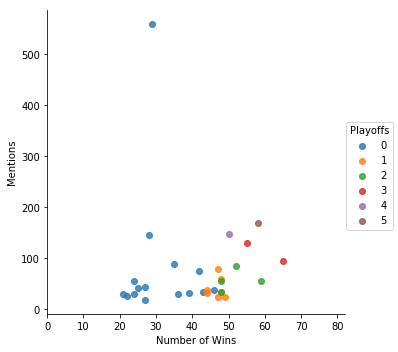

In [63]:
g = sns.lmplot(x="Wins", y="regular_occurrences", hue = "playoff_round",data=team_names,fit_reg = False, legend = True)
g.set_axis_labels(x_var = "Number of Wins", y_var = "Mentions")
g.axes[0,0].set_xlim(0,82)
plt.show()

Using this we see much more of a parity across all teams (except for the Knicks), with the fewest mentions being the Chicago Bulls at 18.

Let's try to fit a linear regression model to this data to examine the underlying effects of each factor:

In [64]:
from sklearn.linear_model import LinearRegression

In [65]:
model = LinearRegression()

In [66]:
team_names.head()

,Name,Wins,Playoffs,Conference,New York Team,noun_occurrences,playoff_round,regular_occurrences
0,Lakers,35,0,W,0,103,DNQ,88
1,Cavaliers,50,4,E,0,370,NBA Finals,147
2,Warriors,58,5,W,0,521,Champion,168
3,Celtics,55,3,E,0,302,Conference Finals,130
4,Spurs,47,1,W,0,108,First Round,79


In [68]:
team_names.Conference = team_names.Conference.apply(lambda x : 0 if x=="E" else 1)

In [71]:
predictor_cols = ['Wins','Playoffs','Conference','New York Team']
model.fit(team_names[predictor_cols],team_names.regular_occurrences)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [88]:
coefs = zip(predictor_cols,model.coef_)

In [89]:
for coef in coefs:
    print(f"Our model predicts that for a unit increase in {coef[0]}, a team will receive **{round(coef[1],2)}** more mentions in the NYT during the regular season.\n")

Our model predicts that for a unit increase in Wins, a team will receive **-0.52** more mentions in the NYT during the regular season.

Our model predicts that for a unit increase in Playoffs, a team will receive **26.2** more mentions in the NYT during the regular season.

Our model predicts that for a unit increase in Conference, a team will receive **7.36** more mentions in the NYT during the regular season.

Our model predicts that for a unit increase in New York Team, a team will receive **320.02** more mentions in the NYT during the regular season.



Perhaps interesting to note is that being in the Western Conference appears to be a strong predictor of mentions and that actually winning more games would result in less mentions - this seems likely because the data is distorted by the high level of mentions for the Knicks.

## Try dropping New York teams:

In [93]:
team_names.drop([6,24],inplace = True)  # Remove Knicks, Nets

In [94]:
model = LinearRegression()
model.fit(team_names[predictor_cols],team_names.regular_occurrences)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [95]:
coefs = zip(predictor_cols,model.coef_)

In [96]:
for coef in coefs:
    print(f"Our model predicts that for a unit increase in {coef[0]}, a team will receive **{round(coef[1],2)}** more mentions in the NYT during the regular season.\n")

Our model predicts that for a unit increase in Wins, a team will receive **-0.64** more mentions in the NYT during the regular season.

Our model predicts that for a unit increase in Playoffs, a team will receive **27.0** more mentions in the NYT during the regular season.

Our model predicts that for a unit increase in Conference, a team will receive **7.56** more mentions in the NYT during the regular season.

Our model predicts that for a unit increase in New York Team, a team will receive **0.0** more mentions in the NYT during the regular season.



Even when discounting the New York teams winning games still appears to negatively impact the number of mentions. Clearly all the benefit of being a good team is correlated with performing well in the playoffs - each round a team will progress in future is worth 27 more mentions throughout the regular season.

## Remove Playoffs as a predictor:

In [98]:
predictor_cols = ['Wins','Conference']
model = LinearRegression()
model.fit(team_names[predictor_cols],team_names.regular_occurrences)
coefs = zip(predictor_cols,model.coef_)
for coef in coefs:
    print(f"Our model predicts that for a unit increase in {coef[0]}, a team will receive **{round(coef[1],2)}** more mentions in the NYT during the regular season.\n")

Our model predicts that for a unit increase in Wins, a team will receive **1.62** more mentions in the NYT during the regular season.

Our model predicts that for a unit increase in Conference, a team will receive **5.42** more mentions in the NYT during the regular season.



Finally in this case we see a benefit to receiving more wins.

Plotting this with seaborn:

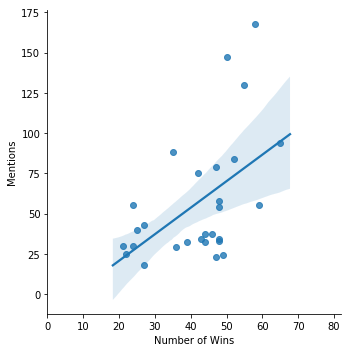

In [100]:
g = sns.lmplot(x="Wins", y="regular_occurrences", data=team_names,fit_reg = True, legend = True)
g.set_axis_labels(x_var = "Number of Wins", y_var = "Mentions")
g.axes[0,0].set_xlim(0,82)
plt.show()

# Sentiment Analysis:

What may be more interesting and insightful is if we can track the performance of teams based on the sentiment of articles written about them.

In [101]:
corpus_blob.sentiment

Sentiment(polarity=0.08991123624834538, subjectivity=0.4294470723252638)

In [113]:
corpus.count("Cleveland Cavaliers")

80

Read in files one by one cleverly. Most of work goes into this one step. Pay attention to dates and consider scraping records.